## Tarea 2: Recomendación de artículos y segmentación temática: Doc2Vec + Kmeans

In [54]:
#Importamos las librerías
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import csv
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy.sparse import coo_matrix
from gensim.models.keyedvectors import KeyedVectors
from gensim.test.utils import common_texts,get_tmpfile
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Doc2Vec
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#importamos los datos
data =pd.read_csv('train.csv')

In [5]:
#importamos los datos
data_test=pd.read_csv('test.csv')

In [6]:
#unimos los data sets
result = pd.concat([data, data_test], axis=0)

In [8]:
result=result.reset_index().drop(columns='index')

In [9]:
result['abstract']=result['abstract'].astype(str)

In [10]:
result=result.reset_index().drop(columns='index')

In [12]:
labels = result[['label']]

labels2 = pd.concat([labels.drop('label', 1), labels['label'].str.get_dummies(sep=";")], 1)

In [13]:
#definimos las stop words
stop_words = set(stopwords.words("english"))##Creating a list of custom stopwords
new_words = ["ha", "become", "put", "large", "also", "since", "one", "two", "new", "previously", "shown","ng","background","describe","recent","despite","wa","objective"]
stop_words = stop_words.union(new_words)

In [15]:
#creamos el corpus
corpus2 = []
for i in range(0, 39000):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', result['abstract'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    tagged = nltk.pos_tag(text)

    x1 = [(i,j.replace('VBD','r').replace('NNS','n').replace('NN','n').replace('JJ','a').replace('VB','v').replace('vP','v').replace('vN','v').replace('IN','n').replace('RB','a').replace('DT','n').replace('MD','v').replace('aR','n').replace('CC','n').replace('vG','v').replace('TO','n').replace('vZ','v').replace('CD','n').replace('aS','r').replace('W','n').replace('PRP','n').replace('EX','n').replace('Fn','n').replace('nP','n').replace('RP','n').replace('na','n').replace('Pn','n').replace('n$','n').replace('nn','n').replace('nS','n').replace('UH','n').replace('$','n').replace('POS','n').replace('SYM','n').replace('','n').replace('nnn','n').replace('nan','n').replace('nvn','n').replace('nrn','n').replace("n'n'n",'n')) for i,j in tagged]
    ##Remove stop words
    text1=[]
    for word in text:
        if word not in stop_words:
            text1.append(word)
     #Lemmatisation
    lem = WordNetLemmatizer()
    text2 = []
    for word in text1:
        if x1[text.index(word)][1] =='n':
            text2.append(lem.lemmatize(word, pos=x1[text.index(word)][1]))
#     text = [lem.lemmatize(word, pos=x1[i][1]) for word in text if not word in stop_words] 
    text2 = " ".join(text2)
    corpus2.append(text2)

In [16]:
#preparamos los datos para aplicar el algoritmo
d2vtrain=[TaggedDocument((doc),tags=[str(i)])for i, doc in enumerate(corpus2)]

In [17]:
#entrenamos el modelo
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus2)]
model = Doc2Vec(documents, dm=1,dm_mean=1,vector_size=5, window=2, min_count=1, workers=4)

In [18]:
fname = get_tmpfile("my_doc2vec_model")
model.save(fname)
model = Doc2Vec.load(fname)

In [19]:
#obtenemos los vectores
lista =[]
for i in range(0,39000):
    lista.append(model[i])

In [20]:
#ponemos aquí cualquier abstract que queremos encontrar los más similares
similar_to = 1864
similar_abstract = model.dv.most_similar(similar_to)

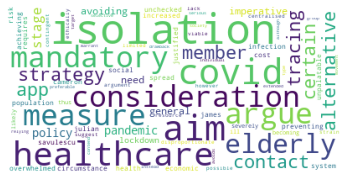

In [21]:
#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

# matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42).generate(str(corpus2[2954]))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [22]:

results=pd.DataFrame(columns = list(labels2.columns))
index_col = []
for i in range(0,10):
    i = similar_abstract[i][0]
    index_col.append(i)
    a_series = pd.Series(labels2.iloc[i].to_numpy().T, index = results.columns)
    results = results.append(a_series, ignore_index=True)

In [23]:
results.index = index_col

In [25]:
for i in results.columns:
    results[i] = pd.to_numeric(results[i])
results.index = results.index.astype(str)

In [26]:
to_predict_series = pd.Series(labels2.iloc[similar_to].to_numpy().T, index = results.columns)
to_predictdf=pd.DataFrame(columns = list(labels2.columns))
to_predictdf = to_predictdf.append(to_predict_series, ignore_index = True)
to_predictdf.index = [similar_to]

In [27]:
results = pd.concat([to_predictdf,results])

In [28]:
import matplotlib.pyplot as plt
import plotly.express as px

## Matriz de etiquetas

In [29]:
px.imshow(results.T)

In [30]:
lista=np.array(lista)

In [31]:
scaler = StandardScaler()
scaler.fit(lista)

lista_norm = scaler.transform(lista)

In [32]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [33]:
import matplotlib.pyplot as plt

## K-means

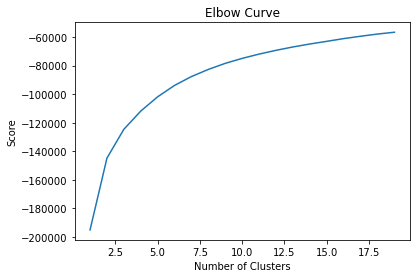

In [34]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(lista_norm).score(lista_norm) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [35]:
kmeans = KMeans(n_clusters=8).fit(lista_norm)
centroids = kmeans.cluster_centers_
print(centroids)

[[-0.10963763  0.45122102 -0.33287    -0.86548746  0.8184388 ]
 [ 0.8110695  -1.3594711  -0.6492089  -0.10850089 -0.7783435 ]
 [ 0.17200324 -0.39923924  0.45993367  0.83393943 -0.44106615]
 [ 0.99932444 -0.46597612  1.2066845  -1.1749966   0.16321015]
 [ 1.3856497  -0.9132605  -0.40331388 -0.11153412  0.94456434]
 [-1.1124203   1.2368473   1.0363113  -0.3347467  -0.42492574]
 [-0.93763536  0.34816372 -0.7458902   0.46982265 -0.930717  ]
 [-0.84670556  0.9770771  -0.15930055  0.8257884   0.7460372 ]]


In [36]:
labels=kmeans.labels_

In [37]:
labels2=labels2[:39000]

In [39]:
labels2['cluster']=labels

In [41]:
labels2['cluster']=labels2['cluster']+1

In [42]:
import seaborn as sns

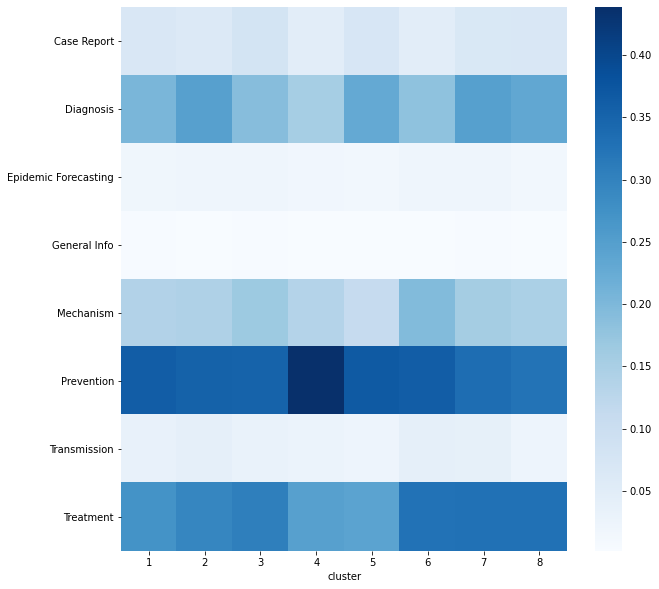

In [43]:
#mapa de calor
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(labels2.groupby('cluster').mean().T, cmap='Blues')

In [44]:
labels
label_0 = np.where(labels == 0)
corpus_np = np.array(corpus2)

In [45]:
label_0 = np.where(labels == 0)
label_1 = np.where(labels == 1)
label_2 = np.where(labels == 2)
label_3 = np.where(labels == 3)
label_4 = np.where(labels == 4)
label_5 = np.where(labels == 5)
label_6 = np.where(labels == 6)
label_7 = np.where(labels == 7)
cluster0 = corpus_np[label_0]
cluster1 = corpus_np[label_1]
cluster2 = corpus_np[label_2]
cluster3 = corpus_np[label_3]
cluster4 = corpus_np[label_4]
cluster5 = corpus_np[label_5]
cluster6 = corpus_np[label_6]
cluster7 = corpus_np[label_7]

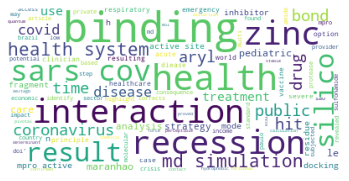

In [46]:

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42).generate(str(cluster0))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

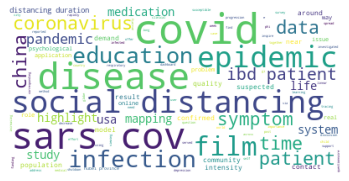

In [47]:

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42).generate(str(cluster1))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

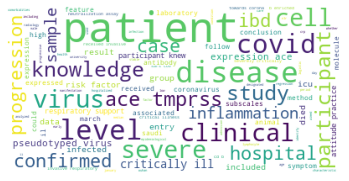

In [48]:

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42).generate(str(cluster2))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

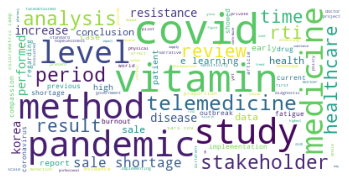

In [49]:

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42).generate(str(cluster3))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

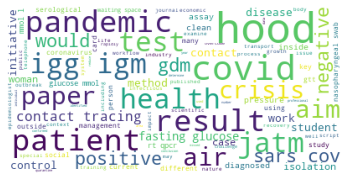

In [50]:

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42).generate(str(cluster4))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

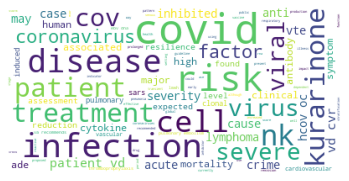

In [51]:

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42).generate(str(cluster5))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

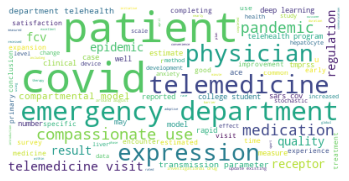

In [52]:

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42).generate(str(cluster6))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

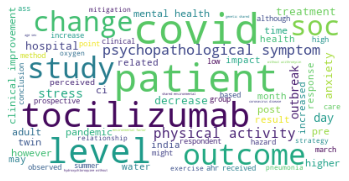

In [53]:

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42).generate(str(cluster7))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)